In [1]:
from HeaderP import *

In [2]:
def log_prior(params):
    m = params[0]
    return -1.5 * np.log(1 + m*m)

def log_marg_prob_scatter(params, S, yn, xn):
    m, b, log_lambda = params
    v = np.array([-m, 1.0])

    # Enforce the log-uniform prior on lambda. 
    if not -5.0 < log_lambda < 5.0:
        return -np.inf

    # Compute \Sigma^2 and \Delta.
    lamd = np.exp(log_lambda)
    Lambda = np.zeros((2,2))
    Lambda[0,0], Lambda[0,1], Lambda[1,0], Lambda[1,1] =  m**2, -m, -m, 1
    Lambda = Lambda * lamd**2/(1+m**2)
    Sigma2 = np.dot(np.dot(S+Lambda, v), v)
    Delta = m * xn + b - yn

    # Compute the log likelihood up to a constant.
    ll = -0.5 * np.sum(Delta**2 / Sigma2 + np.log(Sigma2))
    return ll + log_prior(params)

import emcee

def monoage(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5]):
    colors = getcolor(range(len(agebin)+1))
    plt.figure(figsize=(20,8))
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        r_sing = r_sing[m2]
        feh_sing = feh_sing[m2]
        
        r_ave, feh_ave = movingMed_time(r_sing, feh_sing, 1, 0.1)
        #feh_ave = gaussian_filter(feh_ave, 4)
        """if agebin[i]==12.:
            plt.plot(r_sing, feh_sing,'.', color=colors[i], markersize=1)"""
        plt.plot(r_ave, feh_ave, color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
    plt.grid(color='grey', linestyle='-', linewidth=1)
    plt.xlabel('R [kpc]')
    plt.ylabel('[Fe/H]')
    plt.xlim(xlims)
    plt.ylim(ylims)

def getscatt_bay(feh, r, age, feh_err, r_err, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    
    nwalkers=64
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    scatters_err = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    feherr = feh_err[m]
    rerr = r_err[m]
    
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        feh_err_sing = feherr[m]
        r_err_sing = rerr[m]
        
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                #print(agebin[i], rbins[j], sum(m))
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                feh_err_sing_2 = feh_err_sing[m]
                r_err_sing_2 = r_err_sing[m]
        
                S = np.zeros((len(feh_sing_2),2,2))
                for k in range(len(feh_sing_2)):
                    S[k,0,0] = r_err_sing_2[k]**2
                    S[k,1,1] = feh_err_sing_2[k]**2
                print(agebin[i], rbins[j], len(feh_sing_2))
                z = np.polyfit(r_err_sing_2,feh_sing_2,1)
                sampler_scatter = emcee.EnsembleSampler(nwalkers, 3, log_marg_prob_scatter, args=(S, feh_sing_2, r_sing_2))
                p0 = np.array([z[0], z[1], np.log(0.03)])
                p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
                pos, _, _ = sampler_scatter.run_mcmc(p0, 1000, progress=True)
                sampler_scatter.reset()
                sampler_scatter.run_mcmc(pos, 6000, progress=True)
                samples_scatter = sampler_scatter.flatchain

                """# m
                mcmc = np.percentile(samples_scatter[:, 0], [16, 50, 84])
                q = np.diff(mcmc)
                hi_m[i,0], hi_m[i,1], hi_m[i,2] = mcmc[1], q[0], q[1]

                # b
                mcmc = np.percentile(samples_scatter[:, 1], [16, 50, 84])
                q = np.diff(mcmc)
                hi_b[i,0], hi_b[i,1], hi_b[i,2] = mcmc[1], q[0], q[1]"""

                # dispersion
                mcmc = np.percentile(samples_scatter[:, 2], [16, 50, 84])
                q = np.diff(mcmc)
                scatters[i,j], dishi, dislow = mcmc[1], q[0], q[1]
                scatters_err[i,j] = np.mean(abs(dishi)+abs(dislow))

                
    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters, scatters_err


def getscatt(feh, r, age, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    if len(feherr)>0:
            feherr = feherr[m]
    
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        if len(feherr)>0:
            feh_err_sing = feherr[m]
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                p = fitpoints(r_sing_2, feh_sing_2) 
                scatters[i,j] = np.std(feh_sing_2-p(r_sing_2))

                if len(feherr)>0:
                    feh_err_sing_2 = feh_err_sing[m]
                    scatters[i,j] = np.sqrt(scatters[i,j]**2-np.mean(feh_err_sing_2)**2)

    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters
    
def monoage_line(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[],plotlegend=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    plt.figure(figsize=(20,8))
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] = np.std(feh_sing[m2]-p(r_sing[m2]))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        plt.plot(r_sing[m2], p(r_sing[m2]), color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    if plotlegend:
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
    plt.xlabel('R [kpc]')
    plt.ylabel('[Fe/H]')
    plt.xlim(xlims)
    plt.ylim(ylims)
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter
    
def getcolor(vrange, cmap=plt.cm.get_cmap('plasma')):
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    #print([cmap(norm(i)) for i in vrange])
    return [cmap(norm(i)) for i in vrange]


def avr(age, r, vz, rbin=np.linspace(6,12,4), agebin=np.linspace(0,14,10)):
    colors = getcolor(range(len(rbin)+1))
    avrs = np.zeros((len(rbin)-1, len(agebin)-1))
    for i in trange(len(rbin)-1):
        m = (r>rbin[i])&(r<rbin[i+1])
        age_r, r_r, vz_r = age[m], r[m], vz[m]
        for j in range(len(agebin)-1):
            m2 = (age_r>agebin[j])&(age_r<agebin[j+1])
            if sum(m2)<10:
                avrs[i,j]=np.nan
            else:
                vz_r_age = vz_r[m2]
                avrs[i,j] = 1.5*sum(abs(vz_r_age-np.median(vz_r_age)))/sum(m2)
    return (agebin[:-1]+agebin[1:])/2, (rbin[:-1]+rbin[1:])/2, avrs
    

ModuleNotFoundError: No module named 'emcee'

# Check simiulation with a bar

In [3]:
pd.read_pickle('../NIHAORbirth/g2.79e12_z_0_decomp.pkl').columns


Index(['z', 'metals', 'rxy', 'y', 'mass', 'eps', 'x', 'phi', 'j_circ', 'ke',
       'te', 'decomp', 'j_x', 'j_y', 'tform', 'iord', 'j_z', 'vy', 'vz',
       'vcxy', 'jz_by_jzcirc', 'vx', 'ofe', 'feh', 'age', 'Rbir', 'zbir', 'R',
       'dR', 'dz', 'vc', 'Rg'],
      dtype='object')

In [4]:
#simNo='6_96e11'
simNo='2_79e12'
#simNo='7_55e11'
#z='0'
#z='0_097' 
#z='0_255'
z='0'
# app-center passage
#z='0_25' 
#z='0_2' 
#z='0_195' 
#z='0_19' 
#z='0_1' 
# peri-center passage
#z='0_34' 
#z='0_35' 
#z='0_36' 
Rcut=True
select=False
Rcut_thread=30
zcut_thread=5

Index(['vx_birth', 'vy_today', 'vz_today', 'z_today', 'vy_birth', 'ofe',
       'iords', 'vx_today', 'x_today', 'feh', 'x_birth', 'y_birth', 'vz_birth',
       'mass', 'y_today', 'oxh', 'z_birth', 'age', 'iord', 'vx', 'vy', 'vz',
       'x', 'y', 'z', 'Jr', 'Jphi', 'Jz', 'R', 'R_bir', 'feh_scale',
       'ofe_scale'],
      dtype='object')

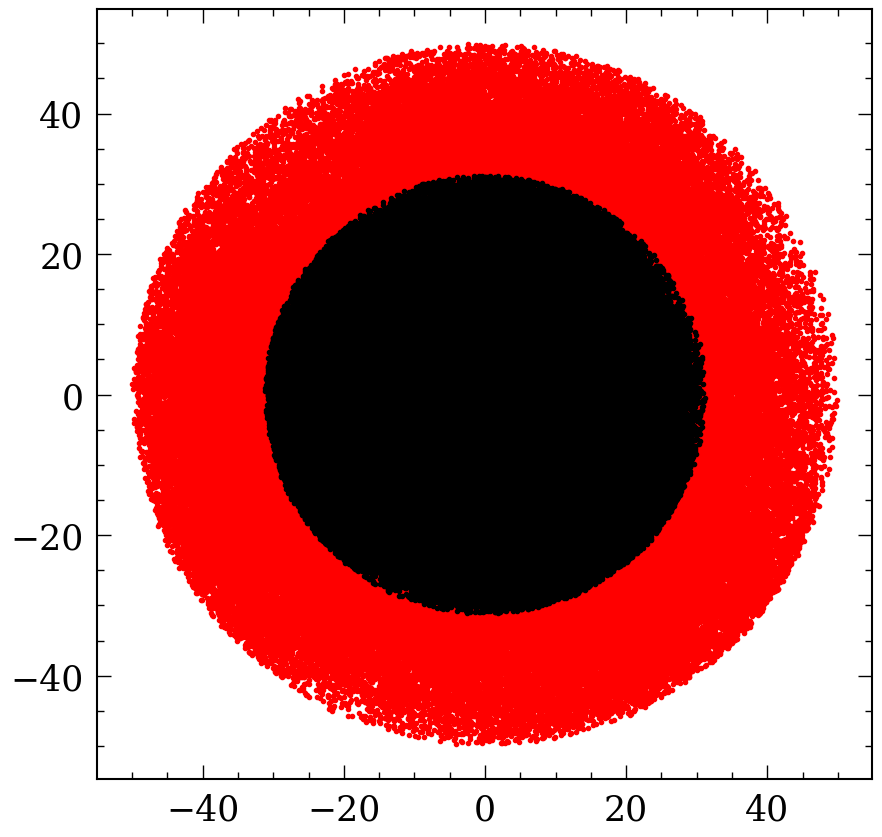

In [6]:


if simNo=='data':
    data=pd.read_pickle('../SecondYear/CannonDR16_cut.pkl')
    data['z_today']=data['z']
    data['x_today']=data['X']
    data['y_today']=data['Y']
    data['feh_scale']=data['M_H']
    data['ofe_scale']=data['O_FE']
    data['age']=data['Age']
elif select:
    data=pd.read_pickle('Data/Buck_g'+simNo+'_apogee_selec.pkl')
    data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
    data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
    scale_fe=0.250019907951355/np.std(data['feh'])
    scale_o=0.10861970484256744/np.std(data['ofe'])
    data['feh_scale']=data['feh']*scale_fe-0.0906638577580452-np.mean(data['feh'])
    data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-np.mean(data['ofe'])
elif not select:
    if z=='0':
        data=pd.read_pickle('../SimulationData/Data/Buck_g'+simNo+'.pkl')
        #rg = pd.read_pickle('../NIHAORbirth/g'+simNo.split('_')[0]+'.'+simNo.split('_')[1]+'_z_0_decomp.pkl')
        #data = pd.merge(data, rg[['iord','Rg']], left_on='iord', right_on='iord',
        #               how='inner')
    else:
        data=pd.read_pickle('../SimulationData/Data/Buck_g'+simNo+'_z'+z+'.pkl')
        try:
            data['x_today']=data['x']
            data['y_today']=data['y']
            data['z_today']=data['z']
        except:
            print(np.shape(data['x_today']))
        
    data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
    data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
    scale_fe=0.250019907951355/np.std(data['feh'])
    scale_o=0.10861970484256744/np.std(data['ofe'])
    data['feh_scale']=data['feh']*scale_fe-0.0906638577580452-np.mean(data['feh'])
    data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-np.mean(data['ofe'])
    
plt.plot(data['x'], data['y'], 'r.')
        
vscale = 240/340
rscale = 3.5/5.6
data['vx'] = data['vx']*vscale
data['vy'] = data['vy']*vscale
data['vz'] = data['vz']*vscale

data['vx_birth'] = data['vx_birth']*vscale
data['vy_birth'] = data['vy_birth']*vscale
data['vz_birth'] = data['vz_birth']*vscale

data['R'] = data['R']*rscale
#data['Rg'] = data['Rg']*rscale
data['R_bir'] = data['R_bir']*rscale
data['x'] = data['x']*rscale
data['y'] = data['y']*rscale
data['z'] = data['z']*rscale

data['Jr'] = data['Jz']*rscale*rscale
data['Jphi'] = data['Jphi']*rscale*rscale
data['Jz'] = data['Jz']*rscale*rscale

plt.plot(data['x'], data['y'], 'k.')
if Rcut:
    data=data.loc[data['R_bir']<Rcut_thread].reset_index(drop=True)
    data=data.loc[abs(data['z_birth'])<zcut_thread].reset_index(drop=True)
        
data.columns

In [24]:
import Astraea
data['zbir'] = abs(data['z_birth'])
data['vr'] = (data['x'] * data['vx'] + data['y'] * data['vy'])/data['R']
data['vphi'] = -(data['x'] * data['vy'] - data['y'] * data['vx'])/data['R']


data['vr_b'] = (data['x_birth'] * data['vx_birth'] + data['y_birth'] * data['vy_birth'])/data['R_bir']
data['vphi_b'] = -(data['x_birth'] * data['vy_birth'] - data['y_birth'] * data['vx_birth'])/data['R_bir']

data['v_tot_bir'] = np.sqrt(data['vx_birth']**2+data['vy_birth']**2+data['vz_birth']**2)


In [25]:


regr, regr_outs = Astraea.RFregressor(data, ['age', 'ofe', 'feh'],
                                      target_var='v_tot_bir', 
                                      target_var_err='v_tot_bir', n_estimators=3)



Simpliest example:
 regr,regr_outs = RFregressor(df,testF)

Fraction of data used to train: 0.8
# of Features attempt to train: 3
Features attempt to train: ['age', 'ofe', 'feh']
7530889 stars in dataframe!
7530889 total stars used for RF!
6024711 training stars!


/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:388: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Finished training! Making predictions!
Finished predicting! Calculating statistics!
Median Relative Error is: 0.11580137097366154
Average chi^2 is: 19.410793473178536
Finished!


In [26]:
def plot_result(actrualF,importance,prediction,y_test,y_test_err=[],topn=20,MS=3,labelName='Period'):
    """Plot impurity-based feature importance as well as predicted values vs true values for a random forest model
    
    Args:
      actrualF ([array-like]): Feature used (from function output of RFregressor())
      importance ([array-like]): importance of the model (from function output of RFregressor())
      prediction ([array-like]): Predicted values (from function output of RFregressor())
      y_test ([array-like]): true values (from function output of RFregressor())
      y_test_err (Optional [array-like]): Errors for true values (from function output of RFregressor())
      topn (Optional [int]): How many most important features to plot
      MS (Optional [int]): Markersize for plotting true vs predicted values
      labelName (Optional [string]): Label name
    
    Returns:
      <matplotlib.plot>: importance plot as well as true vs prediction plot
    """
    
    plt.rcParams.keys()
    plt.rc('font', family='serif')
    params = {
   'axes.labelsize': 30,
   'axes.linewidth': 1.5,
   'legend.fontsize': 25,
   'legend.frameon': False,
   'lines.linewidth': 2,
   'xtick.direction': 'in',
   'xtick.labelsize': 25,
   'xtick.major.bottom': True,
   'xtick.major.pad': 10,
   'xtick.major.size': 10,
   'xtick.major.width': 1,
   'xtick.minor.bottom': True,
   'xtick.minor.pad': 3.5,
   'xtick.minor.size': 5,
   'xtick.minor.top': True,
   'xtick.minor.visible': True,
   'xtick.minor.width': 1,
   'xtick.top': True,
   'ytick.direction': 'in',
   'ytick.labelsize': 25,
   'ytick.major.pad': 10,
   'ytick.major.size': 10,
   'ytick.major.width': 1,
   'ytick.minor.pad': 3.5,
   'ytick.minor.size': 5,
   'ytick.minor.visible': True,
   'ytick.minor.width': 1,
   'ytick.right': True,
    }
    plt.rcParams.update(params)

    topn=min([topn,len(actrualF)])
    # zip the importance with its feature name
    list1 = list(zip(actrualF,importance))
    # sort the zipped list
    decend=sorted(list1, key=lambda x:x[1],reverse=True)
    #print(decend)

    # how many features to plot 
    x=range(topn)
    
    ####################  get most important features ############################################################
    y_val=[decend[i][1] for i in range(topn)]
    my_xticks=[decend[i][0] for i in range(topn)]

    plt.figure(figsize=(20,5))
    plt.title('Most important features',fontsize=25)
    plt.xticks(x, my_xticks)
    plt.plot(x, y_val,'k-')
    plt.xlim([min(x),max(x)])
    plt.xticks(rotation=90)
    plt.ylabel('importance')
    ####################  get most important features ############################################################

    # prediction vs true
    if len(y_test_err)==0:
        plt.figure(figsize=(10,8))
        plt.plot(sorted(prediction),sorted(prediction),'k-',label='y=x')
        plt.plot(sorted(prediction),sorted(1.1*prediction),'b--',label='10% Error')
        plt.plot(sorted(prediction),sorted(0.9*prediction),'b--')
        plt.plot(y_test,prediction,'r.',markersize=MS,alpha=0.2)
        plt.ylabel('Predicted '+labelName)
        plt.xlabel('True '+labelName)
        plt.ylim([min(prediction),max(prediction)])
        plt.xlim([min(prediction),max(prediction)])
        plt.legend()
    else:
        plt.figure(figsize=(20,8))
        plt.subplot(1,2,1)
        plt.plot(sorted(prediction),sorted(prediction),'k-',label='y=x')
        plt.plot(sorted(prediction),sorted(1.1*prediction),'b--',label='10% Error')
        plt.plot(sorted(prediction),sorted(0.9*prediction),'b--')
        plt.plot(y_test,prediction,'r.',markersize=MS,alpha=0.2)
        plt.ylabel('Predicted '+labelName)
        plt.xlabel('True Period')
        plt.ylim([min(prediction),max(prediction)])
        plt.xlim([min(prediction),max(prediction)])
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(sorted(prediction),sorted(prediction),'k-',label='y=x')
        plt.plot(sorted(prediction),sorted(1.1*prediction),'b--',label='10% Error')
        plt.plot(sorted(prediction),sorted(0.9*prediction),'b--')
        plt.errorbar(y_test,prediction,xerr=y_test_err,fmt='r.',markersize=MS,alpha=0.2)
        plt.ylabel('Predicted '+labelName)
        plt.xlabel('True '+labelName)
        plt.ylim([min(prediction),max(prediction)])
        plt.xlim([min(prediction),max(prediction)])
        plt.legend()
    
        avstedv=MRE(y_test,prediction,y_test_err)
        print('Median relative error is: ',avstedv)


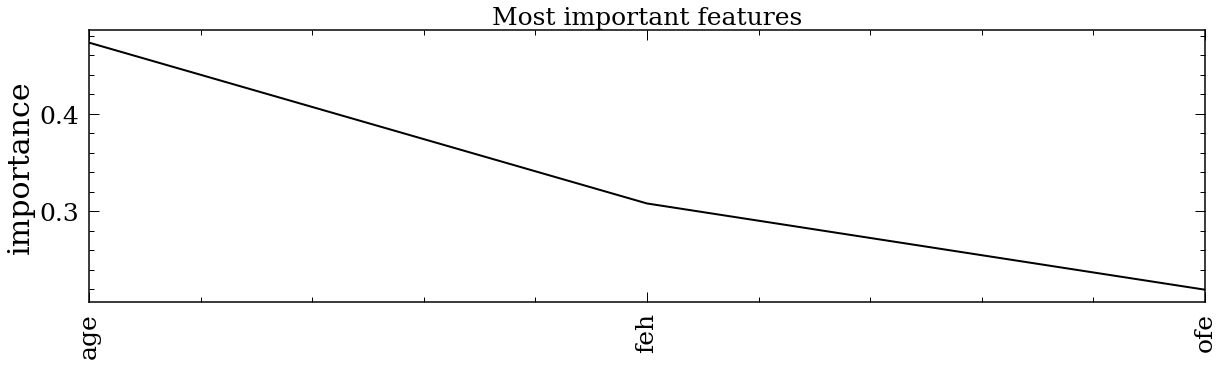

/opt/homebrew/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


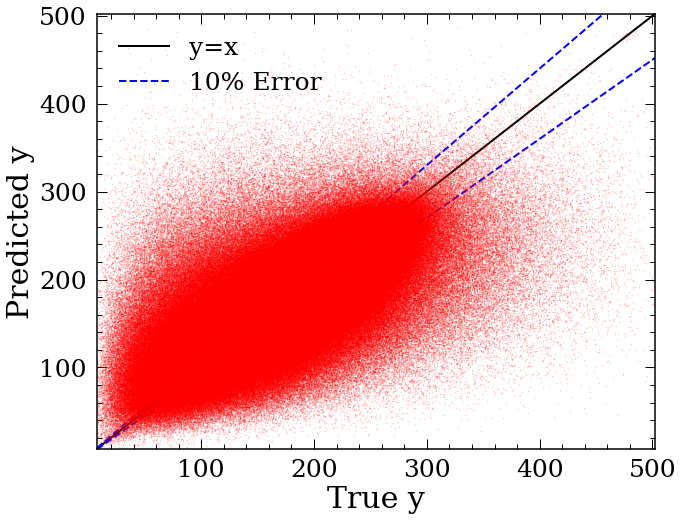

In [27]:
plot_result(regr_outs['actrualF'], regr_outs['importance'], regr_outs['prediction'],
                    regr_outs['y_test'], labelName='y', MS=1)


(0.6711616911347389, 0.0)


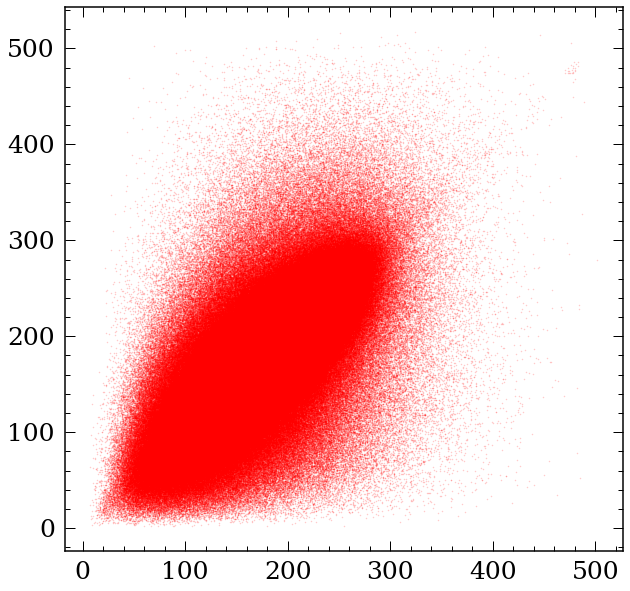

In [29]:
plt.plot(regr_outs['prediction'], regr_outs['y_test'], 'r.', markersize=1, alpha=0.2)
import scipy
print(scipy.stats.pearsonr(regr_outs['prediction'], regr_outs['y_test']))
